## One Node Training

In [2]:
# Importing Librairies
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape, Rescaling
from keras.layers import Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import os

# Force using CPU only by making GPU invisible
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
# Importing & Preprocessing Dataset from Directory
batch_size = 32
img_height = 150
img_width = 150
train_dir = 'rps_dataset/rps'
test_dir = 'rps_dataset/rps-test-set'
valid_dir = 'rps_dataset/rps-validation'

# Data Augmentation
datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range = 90,
        shear_range=0.2,
        zoom_range=0.4,
        horizontal_flip=True,
        vertical_flip=True)

train_ds = datagen.flow_from_directory(
        train_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

valid_ds = datagen.flow_from_directory(
        valid_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

test_ds = datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')

Found 2520 images belonging to 3 classes.
Found 33 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


In [ ]:
# Import Dataset from Hard-Drive
batch_size = 32
img_height = 150
img_width = 150
train_dir = './rps_dataset/rps'
test_dir = './rps_dataset/rps-test-set'
valid_dir = './rps_dataset/rps-validation'

# Training Dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  subset=None,
  interpolation="bilinear",
  follow_links=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Test Dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  subset=None,
  interpolation="bilinear",
  follow_links=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

# Validation Dataset
valid_ds = tf.keras.utils.image_dataset_from_directory(
  valid_dir,
  subset=None,
  interpolation="bilinear",
  follow_links=False,
  image_size=(img_height, img_width),
  batch_size=batch_size)

In [4]:
# Create and Compile Model
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(150, 150, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 75, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                    

In [5]:
# callback
accuracy_threshold = 1.1
class my_callback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        if logs.get('accuracy') >= accuracy_threshold:
            print('\nFor Epoch', epoch, '\nAccuracy has reach = %2.2f%%' %(logs['accuracy']*100), 'training has been stopped.')
            self.model.stop_training = True

In [6]:
# Training and Evaluating Model
history = model.fit(train_ds, validation_data = valid_ds, epochs = 30, callbacks = [my_callback()])
score = model.evaluate(test_ds)

Epoch 1/30
79/79 [==============================] - 19s 188ms/step - loss: 1.1042 - accuracy: 0.3310 - val_loss: 1.0996 - val_accuracy: 0.3636
Epoch 2/30
79/79 [==============================] - 14s 171ms/step - loss: 0.9849 - accuracy: 0.5135 - val_loss: 0.9988 - val_accuracy: 0.6061
Epoch 3/30
79/79 [==============================] - 14s 174ms/step - loss: 0.7539 - accuracy: 0.6671 - val_loss: 1.0689 - val_accuracy: 0.6061
Epoch 4/30
79/79 [==============================] - 14s 174ms/step - loss: 0.4912 - accuracy: 0.7944 - val_loss: 0.6268 - val_accuracy: 0.7576
Epoch 5/30
79/79 [==============================] - 14s 172ms/step - loss: 0.3519 - accuracy: 0.8722 - val_loss: 0.5035 - val_accuracy: 0.7879
Epoch 6/30
79/79 [==============================] - 14s 174ms/step - loss: 0.2588 - accuracy: 0.9020 - val_loss: 0.9937 - val_accuracy: 0.6970
Epoch 7/30
79/79 [==============================] - 14s 174ms/step - loss: 0.2172 - accuracy: 0.9210 - val_loss: 0.8309 - val_accuracy: 0.7273

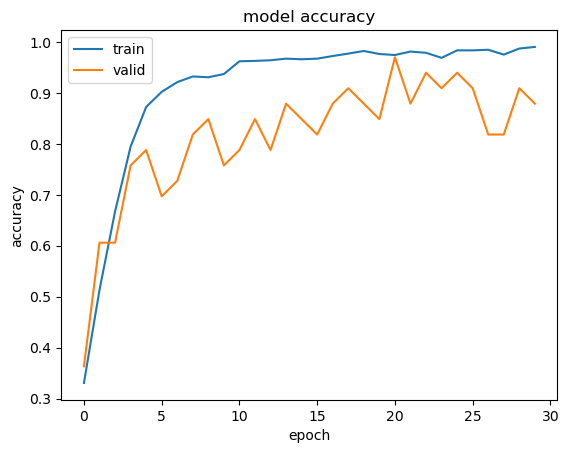

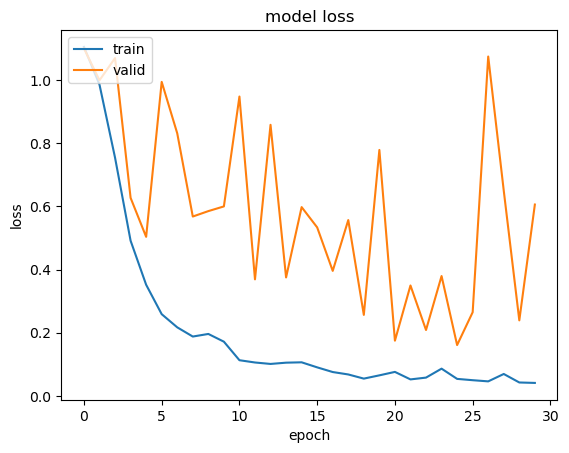

In [7]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()